In [68]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [69]:
def get_url(month):
    url = f'https://www.basketball-reference.com/leagues/NBA_2025_games-{month}.html'
    return url

## Setting the table headings

In [70]:
response = requests.get(get_url('december'))
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table',class_ = {'suppress_glossary', 'sortable', 'stats_table', 'now_sortable'})
headings = [th.text for th in table.find('thead').find_all('th')]
headings[3] = 'PTS_Visitor'
headings[5] = 'PTS_Home'
fixtures = pd.DataFrame(columns=headings)
fixtures

,Date,Start (ET),Visitor/Neutral,PTS_Visitor,Home/Neutral,PTS_Home,,,Attend.,LOG,Arena,Notes


## Adding schedules for all the months

In [71]:
months = ['october', 'november', 'december', 'january', 'february', 'march', 'april']

def add_table_data(table):
    table_body = table.find('tbody')
    for row in table_body.find_all('tr'):
        data = []
        row_date = row.find('th')
        data.append(row_date.text)
        for td in row.find_all('td'):
            data.append(td.text) 
        fixtures.loc[len(fixtures)] = data

In [72]:
for month in months:
    url = get_url(month)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table',class_ = {'suppress_glossary', 'sortable', 'stats_table', 'now_sortable'}) 
    add_table_data(table)
    


In [73]:
fixtures.to_csv('fixtures_and_schedule', index=False)

In [74]:
fixtures.replace('', np.nan, inplace = True)

In [75]:
completed_fixtures = fixtures.dropna(subset=['PTS_Visitor', 'PTS_Home'])

#Removing the in-season tournament
completed_fixtures = completed_fixtures[completed_fixtures['Notes'] != 'In-Season Tournament']

completed_fixtures['PTS_Home'] = completed_fixtures['PTS_Home'].astype(int)
completed_fixtures['PTS_Visitor'] = completed_fixtures['PTS_Visitor'].astype(int)

In [76]:
future_fixtures = fixtures[fixtures['PTS_Visitor'].isna() | fixtures['PTS_Home'].isna()]

### Getting Home and Away fixtures for a team

In [77]:
def get_home_fixtures(team):
    home_fixtures = completed_fixtures[completed_fixtures['Home/Neutral'] == team]
    home_fixtures['Result'] = np.where(home_fixtures['PTS_Home'] > home_fixtures['PTS_Visitor'], "W", "L")
    return home_fixtures

def get_away_fixtures(team):
    away_fixtures = completed_fixtures[completed_fixtures['Visitor/Neutral'] == team]
    away_fixtures['Result'] = np.where(away_fixtures['PTS_Visitor'] > away_fixtures['PTS_Home'], 'W', 'L')
    return away_fixtures


In [78]:
completed_fixtures.loc[1]['PTS_Visitor']

np.int64(103)

In [79]:
teams = fixtures['Visitor/Neutral'].unique()
teams

array(['New York Knicks', 'Minnesota Timberwolves', 'Indiana Pacers',
       'Brooklyn Nets', 'Orlando Magic', 'Milwaukee Bucks',
       'Cleveland Cavaliers', 'Charlotte Hornets', 'Chicago Bulls',
       'Memphis Grizzlies', 'Phoenix Suns', 'Golden State Warriors',
       'Boston Celtics', 'San Antonio Spurs', 'Oklahoma City Thunder',
       'Philadelphia 76ers', 'Detroit Pistons', 'New Orleans Pelicans',
       'Los Angeles Clippers', 'Miami Heat', 'Toronto Raptors',
       'Houston Rockets', 'Dallas Mavericks', 'Sacramento Kings',
       'Atlanta Hawks', 'Washington Wizards', 'Denver Nuggets',
       'Utah Jazz', 'Portland Trail Blazers', 'Los Angeles Lakers'],
      dtype=object)

In [80]:
list(get_home_fixtures('Denver Nuggets')['Result'].value_counts())

[9, 5]

In [81]:
def get_win_loss(table):
    win, loss = list(table['Result'].value_counts())
    return win, loss

In [82]:
win, loss = get_win_loss(get_home_fixtures('Denver Nuggets'))
print(win, loss)

9 5


In [83]:
win_loss_df = pd.DataFrame(columns = ['Team', 'Home_wins', 'Home_losses', 'Away_wins', 'Away_losses'])

In [84]:
for team in teams:
    table_home = get_home_fixtures(team)
    table_away = get_away_fixtures(team)
    home_win, home_loss = get_win_loss(table_home)
    away_win, away_loss = get_win_loss(table_away)
    row = [team, home_win, home_loss, away_win, away_loss]
    win_loss_df.loc[len(win_loss_df)] = row

### Plotting Wins and Losses

In [85]:
def plot(data):
    plt.barh(win_loss_df.sort_values(data)['Team'], win_loss_df.sort_values(data)[data], color = '#53a6ac')
    plt.title(f'{data} by teams')
    for i, value in enumerate(list(win_loss_df.sort_values(data)[data])):
        plt.text(value + (0.02*value), i, str(value), va = 'center')
    
    plt.tight_layout()
    plt.show()


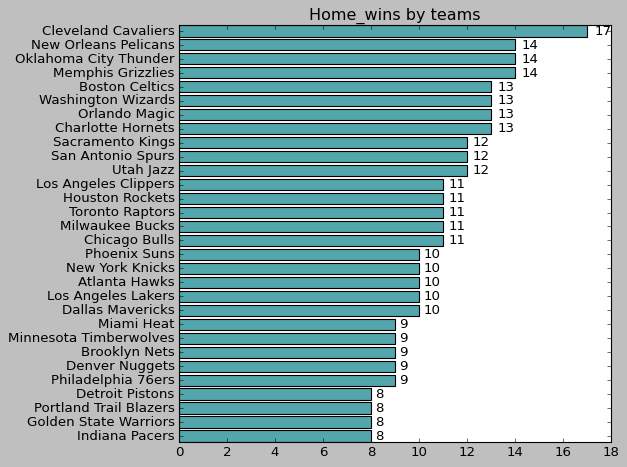

In [86]:
plot('Home_wins')

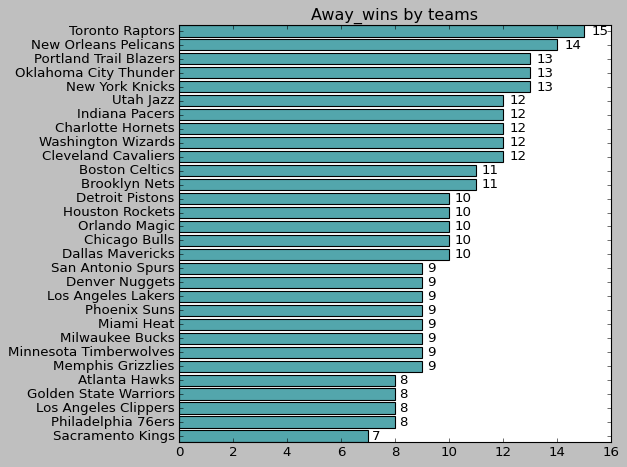

In [87]:
plot('Away_wins')

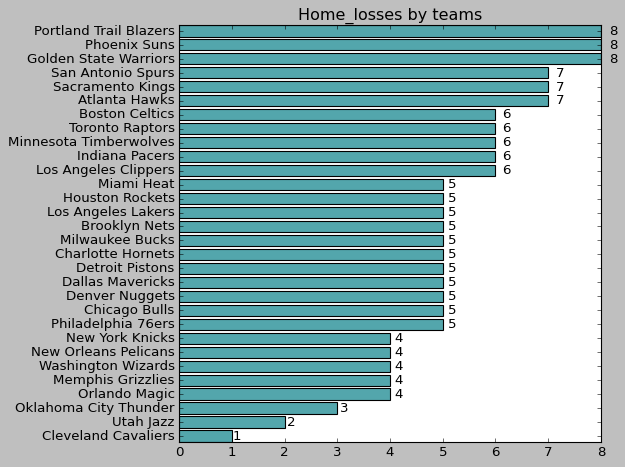

In [88]:
plot('Home_losses')

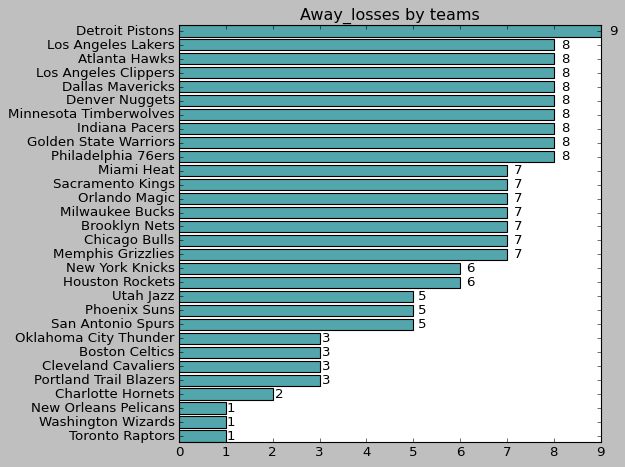

In [89]:
plot('Away_losses')

In [90]:
win_loss_df

,Team,Home_wins,Home_losses,Away_wins,Away_losses
0,New York Knicks,10,4,13,6
1,Minnesota Timberwolves,9,6,9,8
2,Indiana Pacers,8,6,12,8
3,Brooklyn Nets,9,5,11,7
4,Orlando Magic,13,4,10,7
5,Milwaukee Bucks,11,5,9,7
6,Cleveland Cavaliers,17,1,12,3
7,Charlotte Hornets,13,5,12,2
8,Chicago Bulls,11,5,10,7
9,Memphis Grizzlies,14,4,9,7


[329, 156]
[311, 174]


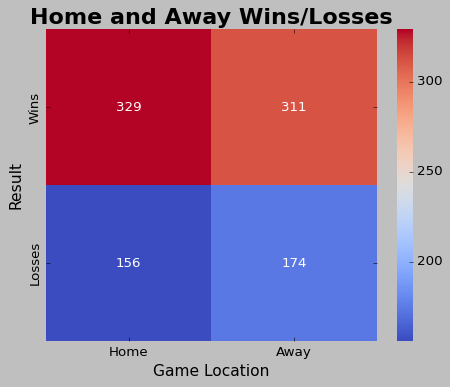

In [91]:
categories = ["Wins", "Losses"]
home = [sum(win_loss_df['Home_wins']),sum(win_loss_df['Home_losses'])]
away = [sum(win_loss_df['Away_wins']),sum(win_loss_df['Away_losses'])]
print(home)
print(away)
# table_data = [[11, 12], [21, 22]]
table_data = [[home[0], away[0]], [home[1], away[1]]]
row_labels = ["Wins", "Losses"]
col_lables = ['Home', 'Away']

plt.figure(figsize = (6,5))
sns.heatmap(table_data, annot=True, fmt='d', cmap="coolwarm", xticklabels=col_lables, yticklabels=row_labels)

plt.title("Home and Away Wins/Losses", fontsize=20, weight="bold")
plt.xlabel("Game Location", fontsize=14)
plt.ylabel("Result", fontsize=14)

plt.tight_layout()
plt.show()

## Home and Away ratings for each team

In [92]:
#timberwolves
team = teams[1]
team

'Minnesota Timberwolves'

In [93]:
def get_metrics(table, place):
    '''
    table: home/away table
    place: 'Home' or 'Visitor'
    '''
    if place == 'Home':
        place1 = 'Home'
        place2 = 'Visitor'
    elif place == 'Visitor':
        place1 = 'Visitor'
        place2 = 'Home'
    else:
        print('Invalid Place value')
        return None
    
    wins = int(table.value_counts('Result')['W'])
    win_rate = wins*100/len(table)
    avg_pts_scored = sum(table[f'PTS_{place1}'])/len(table)
    avg_pts_allowed = sum(table[f'PTS_{place2}'])/len(table)
    pts_diff = avg_pts_scored - avg_pts_allowed 
    data = {'team': team, 
            'wins': wins,
            'win_rate': win_rate, 
            'avg_pts_scored': avg_pts_scored,
            'avg_pts_allowed':  avg_pts_allowed,
            'pts_diff': pts_diff}
    return data


In [94]:
ratings_HA_df = pd.DataFrame(columns = ['Team', 'Home_Rating', 'Away_Rating'])

In [95]:
def get_home_away_ratings(team):
    home_table = get_home_fixtures(team)
    home_metrics = get_metrics(home_table, 'Home')
    home_rating = (0.5 * home_metrics['win_rate'] + 0.3*home_metrics['pts_diff'] + 0.2*home_metrics['avg_pts_scored'])
    away_table = get_away_fixtures(team)
    away_metrics = get_metrics(away_table, 'Visitor')
    away_rating = (0.5 * away_metrics['win_rate'] + 0.3*away_metrics['pts_diff'] + 0.2*away_metrics['avg_pts_scored'])
    return team, home_rating, away_rating

In [96]:
for team in teams:
    ratings_HA_df.loc[len(ratings_HA_df)] = get_home_away_ratings(team)


In [97]:
ratings_HA_df.sort_values('Away_Rating')
ratings_HA_df['Overall_Rating'] = ratings_HA_df['Home_Rating'] + ratings_HA_df['Away_Rating']

In [98]:
def color_scale(series):
    norm = (series - series.min()) / (series.max() - series.min()) 
    return [f'background-color: rgba({255 - int(v * 255)}, {int(v * 255)}, 0, 0.6)' for v in norm]

In [99]:
styled_ratings = ratings_HA_df.style.apply(color_scale, subset=['Home_Rating', 'Away_Rating', 'Overall_Rating'])

In [100]:
styled_ratings

,Team,Home_Rating,Away_Rating,Overall_Rating
0,New York Knicks,62.814286,59.347368,122.161654
1,Minnesota Timberwolves,52.713333,45.617647,98.330980
2,Indiana Pacers,52.178571,41.305000,93.483571
3,Brooklyn Nets,37.057143,40.222222,77.279365
4,Orlando Magic,61.829412,40.788235,102.617647
5,Milwaukee Bucks,58.725000,43.468750,102.193750
6,Cleveland Cavaliers,76.100000,67.026667,143.126667
7,Charlotte Hornets,33.555556,25.835714,59.391270
8,Chicago Bulls,36.406250,53.458824,89.865074
9,Memphis Grizzlies,67.688889,53.893750,121.582639


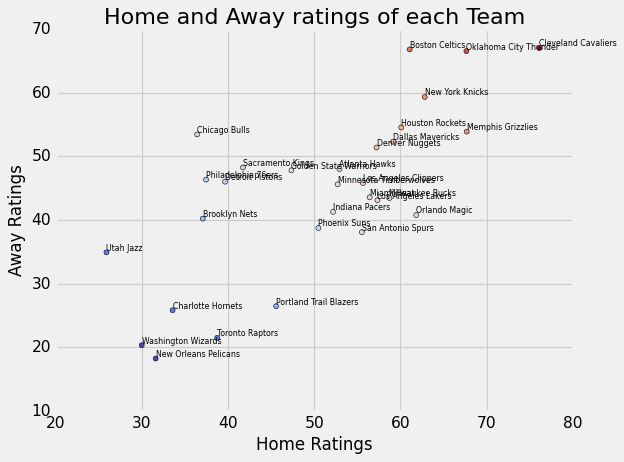

In [101]:
norm = (ratings_HA_df['Overall_Rating'] - ratings_HA_df['Overall_Rating'].min())/(ratings_HA_df['Overall_Rating'].max() - ratings_HA_df['Overall_Rating'].min())

plt.style.use('fivethirtyeight')

plt.scatter(ratings_HA_df['Home_Rating'], ratings_HA_df['Away_Rating'], c= norm, cmap='coolwarm', edgecolors='black')

for i, row in ratings_HA_df.iterrows():
    plt.text(
        row['Home_Rating'],
        row['Away_Rating'],
        row['Team'],
        fontsize = 7, 
        ha = 'left',
        va = 'bottom'
    )

plt.xlabel('Home Ratings', fontsize = 15)
plt.ylabel('Away Ratings', fontsize = 15)
plt.title('Home and Away ratings of each Team', fontsize = 20)

plt.tight_layout()
plt.show()

## Detailed Team Data

In [102]:
pts_data_df = pd.DataFrame(columns = ['Team', 'Home_Scored', 'Home_Allowed', 'Away_Scored', 'Away_Allowed'])
for team in teams:
    home_table = get_home_fixtures(team)
    home_metrics = get_metrics(home_table, 'Home')
    away_table = get_away_fixtures(team)
    away_metrics = get_metrics(away_table, 'Visitor')
    data = [team, home_metrics['avg_pts_scored'], home_metrics['avg_pts_allowed'], away_metrics['avg_pts_scored'], away_metrics['avg_pts_allowed']]
    pts_data_df.loc[len(pts_data_df)] = data


In [103]:
pts_data_df

,Team,Home_Scored,Home_Allowed,Away_Scored,Away_Allowed
0,New York Knicks,119.214286,108.357143,116.842105,110.947368
1,Minnesota Timberwolves,109.066667,106.066667,109.294118,108.529412
2,Indiana Pacers,117.071429,116.428571,112.900000,117.150000
3,Brooklyn Nets,106.285714,113.142857,109.055556,112.500000
4,Orlando Magic,107.647059,100.764706,104.176471,106.294118
5,Milwaukee Bucks,114.812500,110.187500,109.562500,110.625000
6,Cleveland Cavaliers,123.222222,109.111111,121.333333,112.133333
7,Charlotte Hornets,105.666667,110.555556,106.857143,115.785714
8,Chicago Bulls,113.937500,120.625000,120.941176,121.411765
9,Memphis Grizzlies,124.166667,110.944444,122.187500,117.750000


## Poission Distribution of each team points

In [104]:
home_team = 'Cleveland Cavaliers'
away_team = 'Washington Wizards'

In [105]:
#lambda = Avg rate at which the event occurs in a given time/space interval 
#lambda(home) = Avg pts scored by home team ((pts scored by home team + pts conceded by away team) / 2)

def calc_lambda(home_team, away_team, table):
    home = pts_data_df[pts_data_df['Team'] == home_team]
    away = pts_data_df[pts_data_df['Team'] == away_team]
    lambda_h = (float(home['Home_Scored']) + float(away['Away_Allowed']))/2
    lambda_a = (float(home['Home_Allowed']) + float(away['Away_Scored']))/2
    return lambda_h, lambda_a

lambda_home, lambda_away = calc_lambda(home_team, away_team, pts_data_df)

print(f'Expected points scored by {home_team} = {lambda_home}')
print(f'Expected points scored by {away_team} = {lambda_away}')


Expected points scored by Cleveland Cavaliers = 122.53418803418803
Expected points scored by Washington Wizards = 107.59401709401709


In [106]:
#Simulating scores for 10000 matches
n_simulations = 10000
home_scores = np.random.poisson(lambda_home, n_simulations)
away_scores = np.random.poisson(lambda_away, n_simulations)

In [107]:
#Calculating Probabilities
home_wins = np.sum(home_scores > away_scores) / n_simulations
away_wins = np.sum(home_scores < away_scores) / n_simulations
draws = np.sum(home_scores == away_scores)/ n_simulations
print(f"Win Probabilities - {home_team}: {home_wins:.2f}, {away_team}: {away_wins:.2f}, Draw: {draws:.2f}")


Win Probabilities - Cleveland Cavaliers: 0.83, Washington Wizards: 0.16, Draw: 0.02


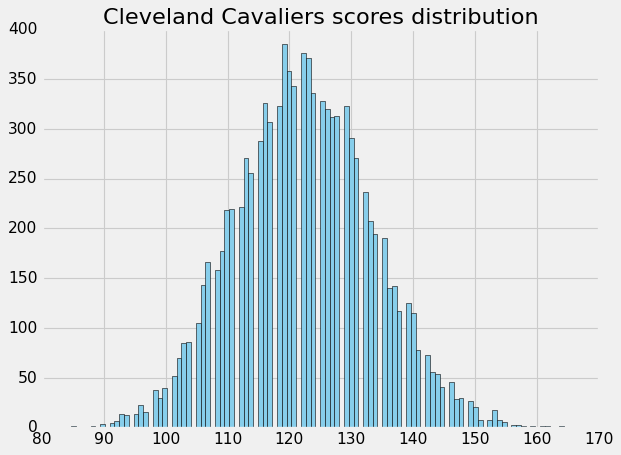

In [108]:
plt.hist(home_scores, bins =110, edgecolor = 'black', color='skyblue')
plt.title(f'{home_team} scores distribution')
plt.show()

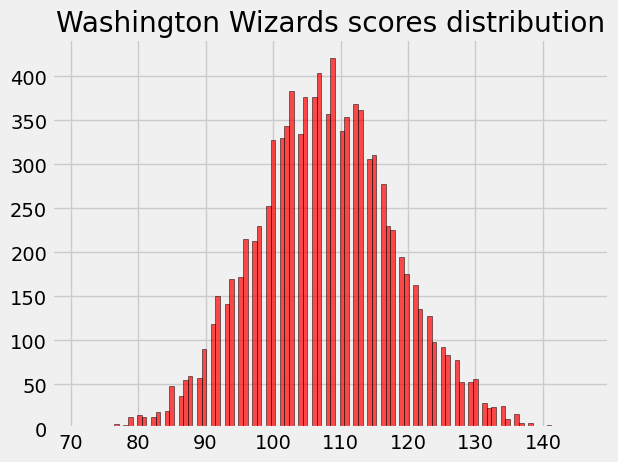

In [64]:
plt.hist(away_scores, bins =110, edgecolor = 'black', alpha = 0.7, color='red')
plt.title(f'{away_team} scores distribution')
plt.show()

In [109]:
'''
Possible Ranges:
<100
100-110
110-120
120-130
130<
'''
score_ranges = ['<100', '100-110', '110-120', '120-130', '130<']

def assign_range(scores):
    conditions = [
        scores < 100, 
        ((scores >= 100) & (scores < 110)),
        ((scores >= 110) & (scores < 120)),
        ((scores >= 120) & (scores < 130)),
        scores >= 130,
    ]
    return np.select(conditions, score_ranges, default='Unknown')

home_ranges = assign_range(home_scores)
away_ranges = assign_range(away_scores)


In [110]:
home_probs = pd.Series(home_ranges).value_counts(normalize=True, sort=False)
away_probs = pd.Series(away_ranges).value_counts(normalize=True, sort=False)

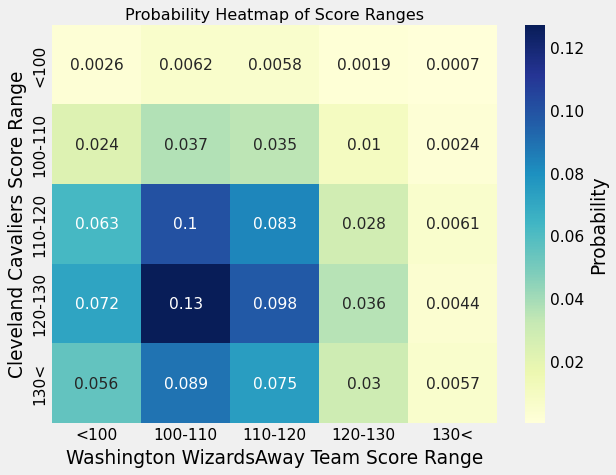

In [111]:
prob_matrix = np.zeros((5, 5))
for i, h_range in enumerate(score_ranges):
    for j, a_range in enumerate(score_ranges):
        prob_matrix[i, j] = (
            ((home_ranges == h_range) & (away_ranges == a_range)).sum() / 10000
        )

# Step 5: Visualize Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    prob_matrix,
    annot=True,
    cmap="YlGnBu",
    xticklabels=score_ranges,
    yticklabels=score_ranges,
    cbar_kws={"label": "Probability"},
)
plt.style.use('classic')
plt.xlabel(f'{away_team}Away Team Score Range')
plt.ylabel(f'{home_team} Score Range')
plt.title("Probability Heatmap of Score Ranges")
plt.show()